### Import All Neccesary Libraries

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import imageio
import os

### Pseudo-random Numbers Seed

Make sure that every pseudo-random numbers is generated with the same sequence every time the code runs.

In [26]:
np.random.seed = 42

### Initializing Global Variables

In [27]:
RANDOM_CONTACTS = 9
CHANCE_OF_INFECTION = 0.06
DAYS_CURED_AFTER = 26
DAYS_TO_DEATH = 14
CHANCE_OF_DEATH = 1.0/DAYS_TO_DEATH
N_EXPERIMENTS = 1
N_STEPS = 150
N_PATIENT_ZERO = 5
N_AGENTS = 3736489
HEALTHCARE_NUM = 62
BED_RATIO = 2
HEALTHCARE_CAPACITY = 2 * N_AGENTS // 1000 * HEALTHCARE_NUM
print(np.ceil(HEALTHCARE_CAPACITY))


463264.0


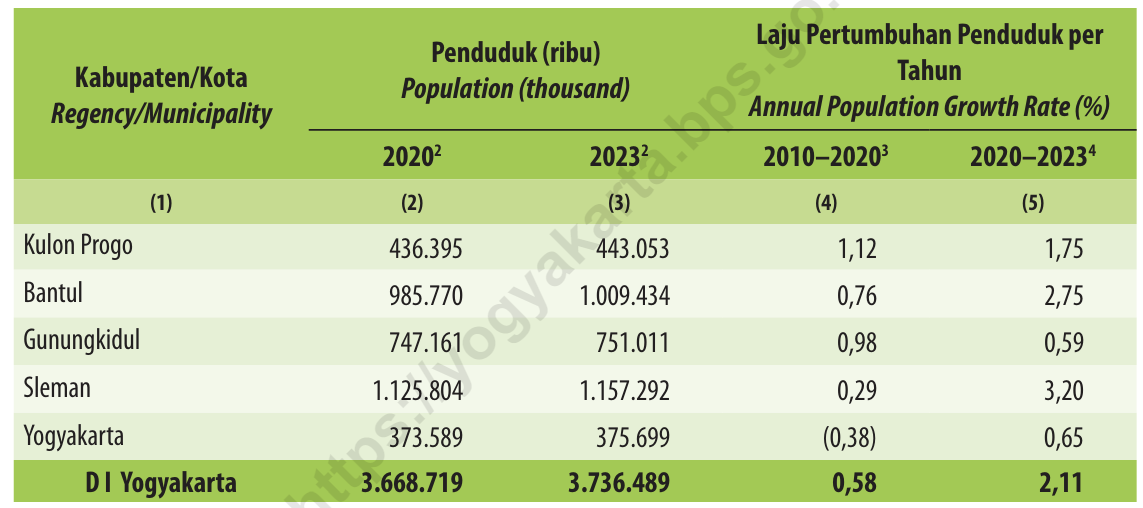

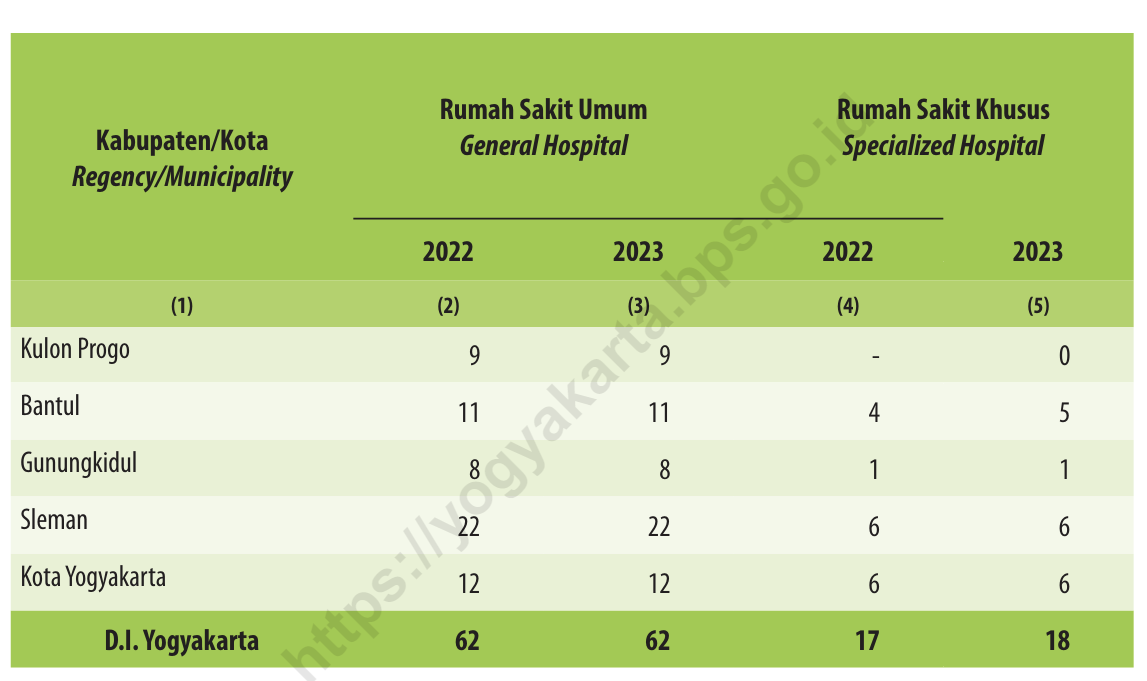

### Initializing SEIRD
Containers for saving numbers of Susceptible, Exposed, Infectious, Recovered, and Death which are counted by its mathematical formulas

In [28]:
class MathModel:
    S = 0
    E = 0
    I = 0
    R = 0
    D = 0
    
    S_ = []
    E_ = []
    I_ = []
    R_ = []
    D_ = []
    
    beta = 0
    sigma = 0
    gamma = 0
    delta = 0
    
    def __init__(self, nAgents=N_AGENTS, nPatientZero=N_PATIENT_ZERO, chanceOfInfection=CHANCE_OF_INFECTION, randomContacts=RANDOM_CONTACTS, daysCuredAfter=DAYS_CURED_AFTER, daysToDeath=DAYS_TO_DEATH):
        
        self.chanceOfInfection = chanceOfInfection
        self.randomContacts = randomContacts
        self.daysCuredAfter = daysCuredAfter
        self.daysToDeath = daysToDeath
        
        self.S = nAgents - nPatientZero
        self.E = 0 
        self.I = nPatientZero
        self.R = 0
        self.D = 0
        
        self.S_ = []
        self.E_ = []
        self.I_ = []
        self.R_ = []
        self.D_ = []
        
        # Contacts with 100% infection rate
        self.beta = self.chanceOfInfection * self.randomContacts

        # Rate from exposed to infectious
        self.sigma = 1.0 / 2 

        # Recovery Rate
        self.gamma = 1.0 / self.daysCuredAfter

        # Death Rate
        self.delta = 1.0 / self.daysToDeath
    
        print("SEIRD Model initialized with:")
        print("Beta:", self.beta)
        print("Sigma:", self.sigma)
        print("Gamma:", self.gamma)
        print("Delta:", self.delta)
        
    def calculateStep(self):
        N = self.S + self.E + self.I + self.R + self.D
        
        S = self.S
        E = self.E
        I = self.I
        R = self.R
        D = self.D

        # Calculate the changing-factor for every variable
        newExposed = self.beta * S * I / N
        newInfected = self.sigma * E
        newRecovered = self.gamma * I
        newDead = self.delta * I
        
        # Update SEIRD for every step
        self.S = S - newExposed
        self.E = E + newExposed - newInfected
        self.I = I + newInfected - newRecovered - newDead
        self.R = R + newRecovered
        self.D = D + newDead

        self.S_.append(self.S)
        self.E_.append(self.E)
        self.I_.append(self.I)
        self.R_.append(self.R)
        self.D_.append(self.D)


### Initializing Agent in A Dataframe
Every agent is initialized with "zero" value as a state of neutral

In [29]:
def agentsDataframe():
    state = np.zeros(N_AGENTS)
    data = {"state":state}
    df = pd.DataFrame(data)
    df.describe()
    return df

df = agentsDataframe()

### Initializing Infect Function

In [30]:
def infect(df, contacts, probability=1.0):
    unique, counts = np.unique(contacts, return_counts=True)
    roll = np.random.uniform(0,1,len(unique))
    state = df.loc[unique, "state"]
    probability = 1 - np.power(1-probability, counts)
    chance = np.array(roll <= probability).astype(int)
    df.loc[unique, "state"] = state + np.maximum(chance * (1-state),0)

### Initializing Death Function

In [31]:
def death(df, probability = CHANCE_OF_DEATH):
    roll = np.random.uniform(0,1,len(df[df["state"] == 1]))
    chance = np.array(roll <= probability).astype(int)
    df.loc[df["state"] == 1, "state"] = 1 + chance

### Initializing Agent for its own State and the Neighborhood

In [32]:
def initAgents(nAgents = N_AGENTS, nPatientZero = N_PATIENT_ZERO):
    state = np.zeros(nAgents)
    neighborhood = np.zeros(nAgents)
    data = {"state":state, "neighborhood":neighborhood}
    df = pd.DataFrame(data)
    patientZero = np.random.choice(df.index, nPatientZero, replace=False)
    infect(df, patientZero, probability=1.0)
    return df

### Plot SEIRD Graph
This graph helps us to look at numbers on every SEIRD condition

In [33]:
def plotSEIRDGraph(x, SEIRDModel, figName="GraphResult.png"):

    plt.plot(x,SEIRDModel.S_, color = "green", label="Susceptible - SEIRD")
    plt.plot(x,SEIRDModel.E_, color = "purple", label="Exposed - SEIRD")
    plt.plot(x,SEIRDModel.I_, color="yellow", label="Infected - SEIRD")
    plt.plot(x,SEIRDModel.R_, color="blue", label="Recovered - SEIRD")
    plt.plot(x,SEIRDModel.D_, color="red", label="Death - SEIRD")
    plt.plot(x, HEALTHCARE_CAPACITY, color = "black", label = "Healthcare Capacity")
    plt.xlabel("Time steps [days]")
    plt.ylabel("Number of cases")

    lgd = plt.legend(loc="upper right")
    # plt.tight_layout()
    
    plt.savefig(figName, bbox_extra_artists=(lgd,), bbox_inches='tight')
   
    plt.show()

### Making Ways for Every Agent to Walk Using Moore's Neighborhood Concept

In [34]:
def neighborhoodLattice(df, nRandomContacts=0):
    sideLength = int(np.sqrt(len(df)))
    N = np.array((df.index - sideLength) % len(df)).astype(int)
    E = np.array(np.floor(df.index / sideLength)*sideLength + (df.index % sideLength + 1) % sideLength).astype(int)
    S = np.array((df.index + sideLength) % len(df)).astype(int)
    W = np.array(np.floor(df.index / sideLength)*sideLength + (df.index % sideLength - 1) % sideLength).astype(int)
        
    NE = np.array((E - sideLength) % len(df)).astype(int)
    SE = np.array((E + sideLength) % len(df)).astype(int)
    SW = np.array((W + sideLength) % len(df)).astype(int)
    NW = np.array((W - sideLength) % len(df)).astype(int)
    
    res = [N,E,S,W,NE,SE,SW,NW]
    
    for i in range(0,nRandomContacts):
        res.append(np.random.choice(df.index, len(df), replace=True))
    
    res = np.array(res).T
    return dict(zip(df.index, res))

### Steps for Every Agent

In [35]:
def step(df, mode='random', neighborhood=None):
    nInfected = np.sum(df["state"] == 1)
    contacts = []
    if mode == 'random':
        contacts = np.random.choice(df.index, RANDOM_CONTACTS * nInfected, replace=True)
    elif mode == 'lattice':
        assert np.floor(np.sqrt(len(df))) * np.floor(np.sqrt(len(df))) == len(df)
                                                    
        contacts = [neighborhood[i] for i in df[df["state"] == 2].index]
        contacts = np.array(contacts).flatten()

    infect(df, contacts, CHANCE_OF_INFECTION)
    death(df, CHANCE_OF_DEATH)

### Generate Agents Movement Visualization on a 2D Lattice

In [36]:
def plot_lattice(df, stepNum):
    sideLength = int(np.sqrt(len(df)))
    a = np.array(df["state"] + df["state"]*(2-df["state"]) + df["state"]/2*(1-df["state"])).reshape(sideLength, sideLength)
    plt.imshow(a)
    plt.title("Time step {:03d}".format(stepNum))
    plt.axis('off')
    plt.savefig("gifs/tmp/{:03d}.png".format(stepNum))

### Simulate Agents Movement for Every Condition (Especially Susceptible, Death, and Recovered)

In [37]:
def simulate(df, nSteps=100, mode="random", nRandomContacts=0):
    neighborhood = neighborhoodLattice(df, nRandomContacts)
        
    for i in tqdm(range(nSteps)):        
        step(df, mode, neighborhood)
        plot_lattice(df, i)

### Simulation Started

SEIRD Model initialized with:
Beta: 0.54
Sigma: 0.5
Gamma: 0.038461538461538464
Delta: 0.07142857142857142
Simulate SEIRD Model


100%|██████████| 150/150 [00:00<?, ?it/s]

Starting Experiment: 1 / 1



100%|██████████| 150/150 [48:48<00:00, 19.52s/it]


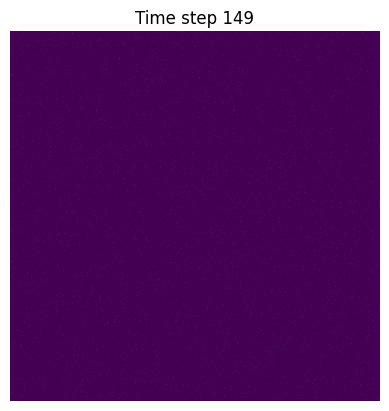

In [38]:
x = np.linspace(0, N_STEPS-1, N_STEPS)
allStats = []

SEIRDModel = MathModel(N_AGENTS, N_PATIENT_ZERO, CHANCE_OF_INFECTION, RANDOM_CONTACTS, DAYS_CURED_AFTER, DAYS_TO_DEATH)

print("Simulate SEIRD Model")
for _ in tqdm(range(N_STEPS)):
    SEIRDModel.calculateStep()

for i in range(N_EXPERIMENTS):
    print("Starting Experiment:", i+1, "/", N_EXPERIMENTS)
    df = initAgents(N_AGENTS)
    st = {"nInfected": [], "nRemoved": [], "nSusceptible": [], "nExposed":[], "nDeath":[]}
    simulate(df, nSteps=N_STEPS, mode="lattice", nRandomContacts=RANDOM_CONTACTS)

    allStats.append(st)

### Plot a Graph for SEIRD condition at the end of steps

ValueError: x and y must have same first dimension, but have shapes (150,) and (1,)

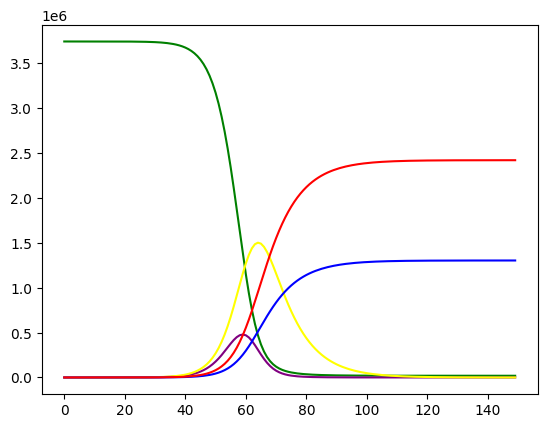

In [39]:
plotSEIRDGraph(x,SEIRDModel)

### Make a GIF from the 2D Lattice

In [ ]:
def createGif(imgDir='gifs/tmp', gifName="result.gif"):
    images = []
    for fileName in sorted(os.listdir(imgDir)):
        if fileName.endswith('.png'):
            filePath = os.path.join(imgDir, fileName)
            images.append(imageio.imread(filePath))
            if len(images) == 78:
                break
    imageio.mimsave(gifName, images, duration=0.1)

createGif()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27508\751662412.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filePath))
